# Adding imports

In [1]:
import requests
import os
import json
import datetime
import logging as logger
import cv2
import numpy as np
import face_recognition

from os.path import join, dirname
from dotenv import load_dotenv
from bs4 import BeautifulSoup
from moviepy.editor import *
from keras.models import model_from_json

2023-12-04 12:06:08.716075: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 12:06:08.717707: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 12:06:08.740937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 12:06:08.740969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 12:06:08.741657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Loading environment and local variables

In [16]:
dotenv_path = join(dirname(os.path.abspath('')), '.env')
load_dotenv(dotenv_path)
os.chdir('/app')

logger.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

def dump_json(data, path):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)


def get_twitch_token():
    payload = {
        'client_id' : os.environ.get("CLIENT_ID"),
        'client_secret': os.environ.get("CLIENT_SECRET"),
        'grant_type': 'client_credentials'
    }
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}
    response = requests.post("https://id.twitch.tv/oauth2/token", headers=headers, data=payload)

    return json.loads(response.text)["access_token"]


token = get_twitch_token()
headers = {'Authorization': f'Bearer {token}', 'Client-Id': os.environ.get("CLIENT_ID")}

In [17]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


In [18]:
def get_streamers():
    '''
    Retreive from a third party website the list of the most watched streamers
    Returns a list of strings
    '''
    results = []
    request = requests.get('https://www.twitchmetrics.net/channels/viewership?game=League+of+Legends&lang=en&page=1')
    parsed_html = BeautifulSoup(request.text)

    for name in parsed_html.body.find_all('h5', attrs={'class':'mr-2 mb-0'}):
        results.append(name.get_text())
    
    return results



In [19]:
def convert_name_to_id(name):
    '''
        Converts the basic name (e.g. Thebausffs) to the broadcaster id, which twitch uses to identify the streamer
        There are some exceptions with names, that involve whitespaces between them: only staff members can use them, and when putting
        the name in the endpoint will result in a error, so the name has to be stripped of it
    '''
    params = { "login" : "".join(name.split()) }
    request = requests.get(f'https://api.twitch.tv/helix/users', headers=headers, params=params)
    if request.ok:
        return json.loads(request.text)["data"][0]["id"]
    else:
        raise Exception(f'Error from twitch endpoint {request.text}')



In [20]:
def clips_from_broadcaster_id(id):
    '''Retreives the clips from a streamer, based also on timeframe, and sorted by views'''
    format_time = "%Y-%m-%dT%H:%M:%SZ"
    params = {
        "broadcaster_id" : id,
        "started_at" : (datetime.datetime.now() - datetime.timedelta(days=3)).strftime(format_time),
        "ended_at" : datetime.datetime.now().strftime(format_time)
    }
    request = requests.get(f'https://api.twitch.tv/helix/clips', headers=headers, params=params)
    return json.loads(request.text)["data"]



In [25]:
def download_clip(clip):
    path = f'/app/files/clips/{clip["title"]}.mp4'
    index = clip["thumbnail_url"].find('-preview')
    clip_url = clip["thumbnail_url"][:index] + '.mp4'
    r = requests.get(clip_url)

    if r.headers['Content-Type'] == 'binary/octet-stream':
        if not os.path.exists('files/clips'): os.makedirs('files/clips')
        with open(path, 'wb') as f:
            f.write(r.content)
        return path
    else:
        print(f'Failed to download clip from thumb: {clip["thumbnail_url"]}')



In [22]:
def overlay_video(original_video, overlay_video):
    output_path="output.mp4"

    video_clip = VideoFileClip((original_video), target_resolution=(1080, 1920)) #b .mp4 file

    overlay_clip = VideoFileClip((overlay_video), has_mask=True, target_resolution=(1080, 1920)) #.mov file with alpha channel

    final_video = CompositeVideoClip([video_clip, overlay_clip])  


    final_video.write_videofile(
        output_path,
        threads = 6,
    )

In [23]:
def main():
    logger.info('Program started')
    logger.info('BRUH')

    time = 2 * 60
    video_time = 0

    clips = []

    streamers = get_streamers()

    for streamer in streamers:
        if streamer == "Riot Games":
            continue
        streamer_id = convert_name_to_id(streamer)
        clips_downloaded = clips_from_broadcaster_id(streamer_id)[:3]
        if video_time > time:
            break
        for clip in clips_downloaded:
            video_time += float(clip["duration"])
            clips.append(download_clip(clip))
    
    transition_time = 2
    video_clips = [VideoFileClip(clips.pop(0))]
    
    for clip in clips:
        video_clips.append(VideoFileClip(clip).crossfadein(transition_time))

    final = concatenate_videoclips(video_clips, padding=-transition_time, method="compose")
    final.write_videofile("files/clips/final_output.mp4")
    #Adding intro
    overlay_video("files/clips/final_output.mp4", "files/intro.mov")


In [ ]:
main()

In [26]:
time = 2 * 60
video_time = 0

clips = []

streamers = get_streamers()

for streamer in streamers:
    if streamer == "Riot Games":
        continue
    streamer_id = convert_name_to_id(streamer)
    clips_downloaded = clips_from_broadcaster_id(streamer_id)[:3]
    if video_time > time:
        break
    for clip in clips_downloaded:
        video_time += float(clip["duration"])
        clips.append(download_clip(clip))


# Original

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def read_video_emotion(video):

    vidcap = cv2.VideoCapture(f'/app/files/clips/{video}')
    success,image = vidcap.read()
    
    if not success:
        print("Video not correctly loaded, presumably not there")
    
    results_percentage = {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 0}
    labels = {0 : 'angry', 1 : 'disgust', 2 : 'fear', 3 : 'happy', 4 : 'neutral', 5 : 'sad', 6 : 'surprise'}

    
    
    def extract_features(face_image):
        smaller_face_image = cv2.resize(face_image,(48,48))
        feature = np.array(smaller_face_image)
        feature = feature.reshape(1,48,48,1)
        return feature/255.0
    
    json_file = open("/app/files/models/emotion/emotiondetector.json", "r")
    model = model_from_json(json_file.read())
    json_file.close()
    model.load_weights("/app/files/models/emotion/emotiondetector.h5")

    multp = 3
    skip = 0
    
    while success:
        success,image = vidcap.read()

        if success is False:
            break

        #Elaborate 1 in each X frames for efficency. Faces don't change that quicly
        if skip < 90:
            skip += 1
            continue

        skip = 0
        
        #Reduce the size of the image to examine for efficency purposes
        face_locations = face_recognition.face_locations(cv2.resize(image, (0, 0), fx=1/multp, fy=1/multp), model="cnn")
        
        if len(face_locations) == 0:
            continue
        
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        top, right, bottom, left = face_locations[0]
        face_image = gray[top*multp : bottom*multp, left*multp : right*multp]
        imgplot = plt.imshow(face_image)
        plt.show()
        
        extracted_img = extract_features(face_image)
        with HiddenPrints():
            pred = model.predict(extracted_img)
        results_percentage[labels[pred.argmax()]] += 1
        print(labels[pred.argmax()])
    return results_percentage

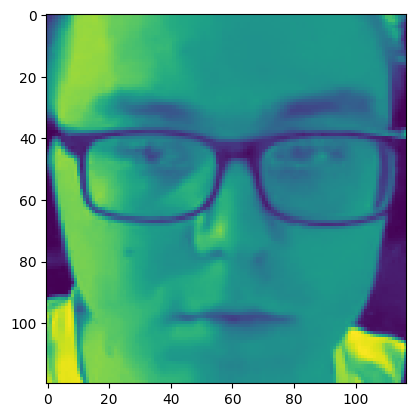

fear


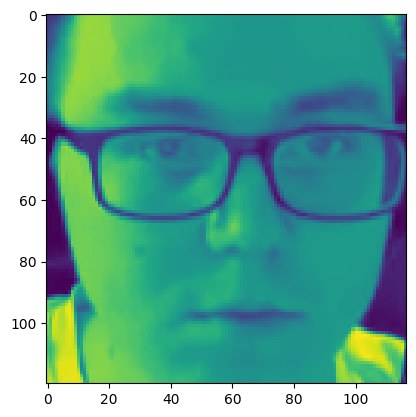

neutral


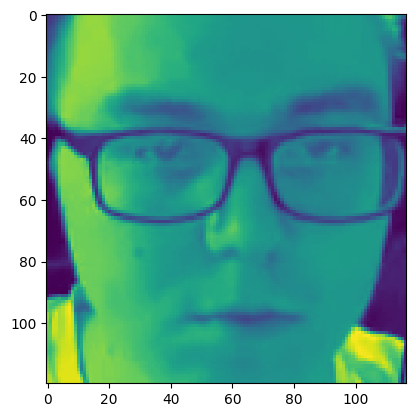

happy


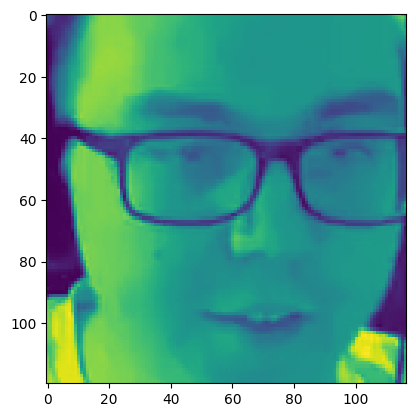

happy


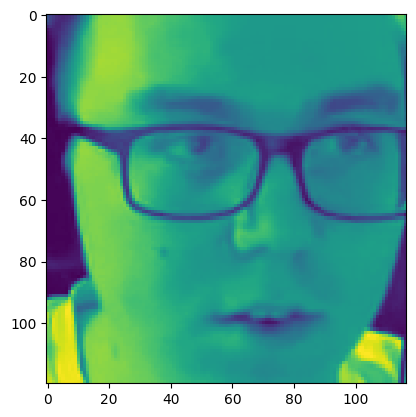

neutral


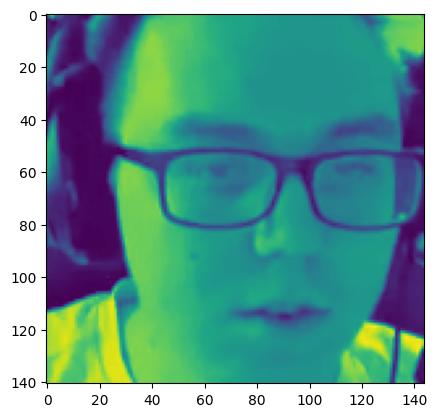

happy


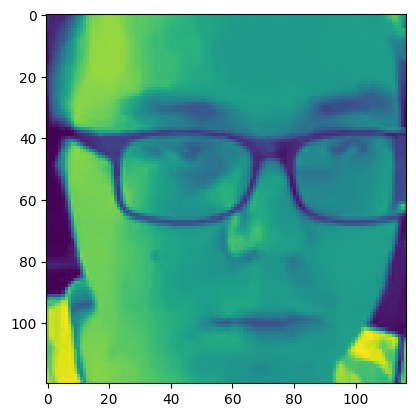

happy


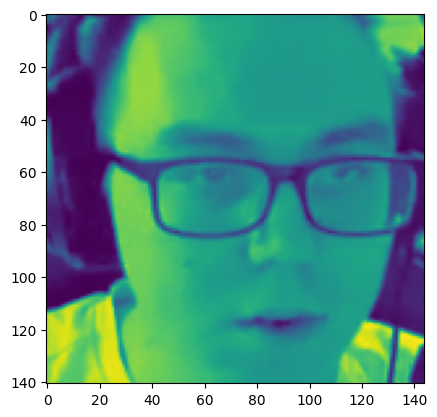

happy


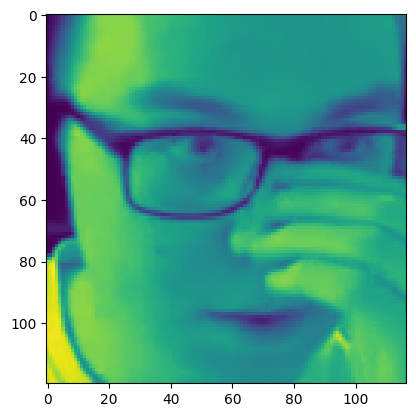

disgust


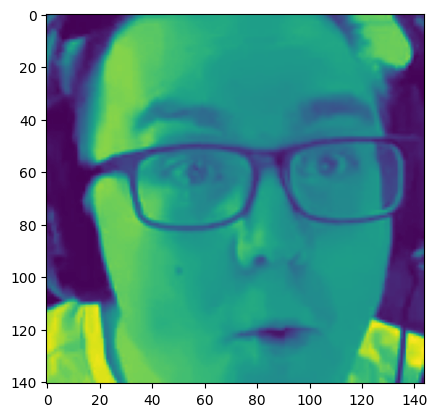

surprise


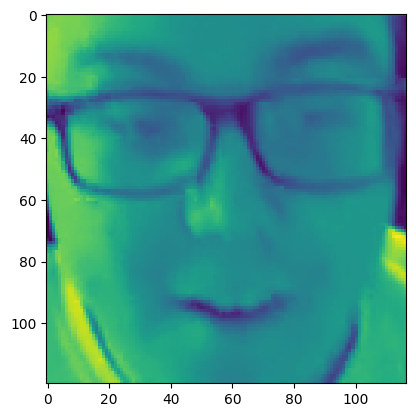

happy


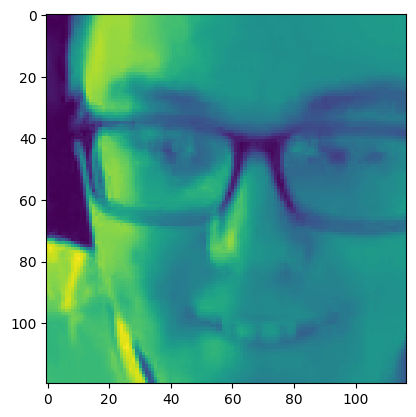

angry


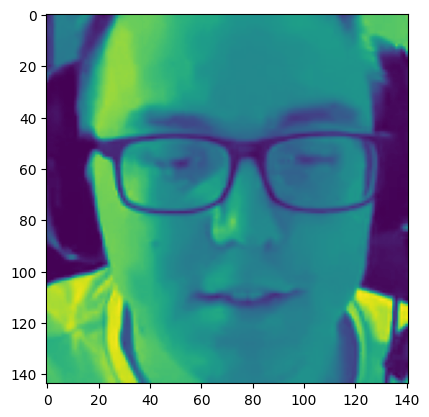

neutral


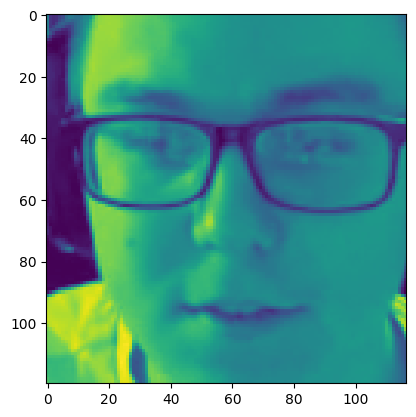

angry


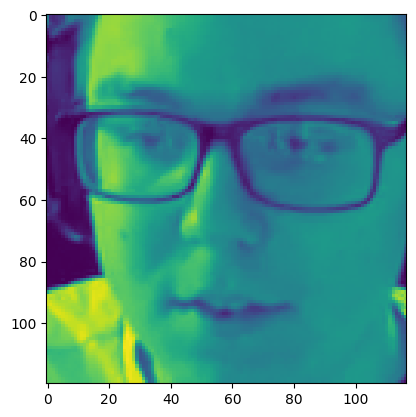

happy


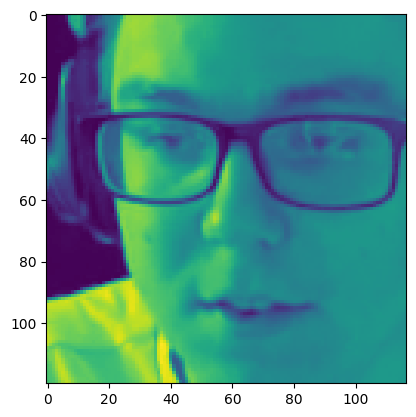

angry


{'angry': 3,
 'disgust': 1,
 'fear': 1,
 'happy': 7,
 'neutral': 3,
 'sad': 0,
 'surprise': 1}

In [15]:
read_video_emotion("b.mp4")

## Riorganizzare i video, in modo semplicistico (felice, brutto, felice, brutto)

In [5]:
bruh = read_video_emotion("ner.mp4")

In [28]:
%%time
results = read_video_emotion('b.mp4')

CPU times: user 1min 18s, sys: 9.31 s, total: 1min 27s
Wall time: 1min 21s


In [ ]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [1]:
import moviepy.editor as mpy
from moviepy.video.fx.all import crop

clip = mpy.VideoFileClip("video.mp4")
(w, h) = clip.size


In [2]:
(w, h)

(1280, 720)

In [3]:
crop_width = h * 9/16
# x1,y1 is the top left corner, and x2, y2 is the lower right corner of the cropped area.

x1, x2 = (w - crop_width)//2, (w+crop_width)//2
y1, y2 = 0, h
cropped_clip = crop(clip, x1=x1, y1=y1, x2=x2, y2=y2)
# or you can specify center point and cropped width/height
# cropped_clip = crop(clip, width=crop_width, height=h, x_center=w/2, y_center=h/2)
cropped_clip.write_videofile('resized.mp4')

Moviepy - Building video resized.mp4.
MoviePy - Writing audio in resizedTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video resized.mp4



Moviepy - Done !
Moviepy - video ready resized.mp4


In [5]:
from moviepy.editor import *
import PIL
PIL.Image.ANTIALIAS = PIL.Image.LANCZOS
video = VideoFileClip("resized.mp4")

title = ImageClip("main.png").set_start(0).set_duration(video.duration).set_pos(("center","center")).resize(height=200)

final = CompositeVideoClip([video, title])
final.write_videofile("test.mp4")

Moviepy - Building video test.mp4.
MoviePy - Writing audio in testTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4
